In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df = df.drop(columns = ['Unnamed: 0'])

In [5]:
df['r(t+1)'] = df.groupby('permno')['return'].shift(-1)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df_filled = df.copy()
for feature in ['mom1m', 'mom12m', 'chmom', 'mom36m', 'turn', 'dolvol', 'idiovol', 'beta', 'betasq', 'ep', 'sp', 'agr', 'nincr']:
    df_filled[feature] = df_filled.groupby('Date')[feature].transform(lambda x: x.fillna(x.median()))

In [8]:
df_filled.isna().sum()

Date             0
permno           0
return           0
mom1m            0
mom12m           0
chmom            0
indmom           0
mom36m           0
turn             0
mvel1            0
dolvol           0
ill              0
zerotrade        0
baspread         0
retvol           0
idiovol          0
beta             0
betasq           0
ep               0
sp               0
agr              0
nincr            0
return(t-1)    500
r(t+1)         500
dtype: int64

In [9]:
df.loc[:, ['mom1m', 'mom12m', 'chmom', 'mom36m', 'turn', 'dolvol', 'idiovol', 'beta', 'betasq', 'ep', 'sp', 'agr', 'nincr']] = df_filled.loc[:,['mom1m', 'mom12m', 'chmom', 'mom36m', 'turn', 'dolvol', 'idiovol', 'beta', 'betasq', 'ep', 'sp', 'agr', 'nincr']]

In [10]:
df.set_index('Date', inplace=True)

# Sorting data into bins

In [11]:
bins = pd.read_pickle('dataframes.pkl')
print(len(bins))
bins

9


[               mom1m    mom12m     chmom    indmom    mom36m      turn  \
 Date                                                                     
 2001-02-28 -1.227217  1.496115  0.464327  2.002047 -0.894952 -0.669719   
 2001-03-31 -0.738248  0.268442  1.028669  0.566989 -0.741515 -0.691479   
 2001-04-30 -0.145482  0.232072  1.139679  0.500932 -0.777376 -0.782179   
 2001-05-31  0.680502  0.196008  1.082926  0.435431 -0.757976 -0.839218   
 2001-06-30 -0.256864  0.793600 -0.192024  1.458838 -0.753031 -0.847905   
 ...              ...       ...       ...       ...       ...       ...   
 2019-08-31 -0.456971 -0.371019  0.000223 -0.594437 -0.279818  0.183965   
 2019-09-30  0.056832 -0.625031  0.057134 -1.055789 -0.268858  0.215138   
 2019-10-31 -0.205827 -0.556172 -0.054997 -0.930723 -0.074809  0.284859   
 2019-11-30 -0.106308 -0.595088  0.232050 -1.001404 -0.065805  0.210304   
 2019-12-31  0.615626 -0.530693  0.744224 -0.884447 -0.188191  0.090279   
 
                mvel1  

# Fitting model

In [12]:
training = df[:'2014-01-01'].dropna()
validation = df['2014-01-02':'2018-01-01']
testing = df[:'2020-01-01'].dropna()

In [13]:
X_train = training.drop(columns = ['permno', 'return', 'r(t+1)'])
y_train = training['r(t+1)']

In [14]:
X_val = validation.drop(columns = ['permno', 'return', 'r(t+1)'])
y_val = validation['r(t+1)']

In [15]:
X_test = testing.drop(columns = ['permno', 'return', 'r(t+1)'])
y_test = testing['r(t+1)']

In [16]:
#Hyperparameters based on the paper
depth = 6 
n_trees = 300         
feature_split = 3 

In [17]:
def R_calc(actual, predicted):

    actual = np.array(actual)
    predicted = np.array(predicted).flatten()
    
    predicted = np.clip(predicted, 0, None)
    
    ss_res = np.sum((actual - predicted) ** 2)
    
    ss_tot = np.sum(actual ** 2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

In [18]:
rf = RandomForestRegressor(n_estimators = n_trees,
                                   max_depth = depth,
                                   max_features = feature_split,
                                   random_state = 42)
        
rf.fit(X_train, y_train)
        
predictions = rf.predict(X_val)
        
r_val = R_calc(y_val, predictions)
        
print(r_val)

0.008260710363663715


In [19]:
test_pred = rf.predict(X_test)
val = R_calc(y_test, test_pred)
print(val)

0.05764657658981798


# PDP Plots

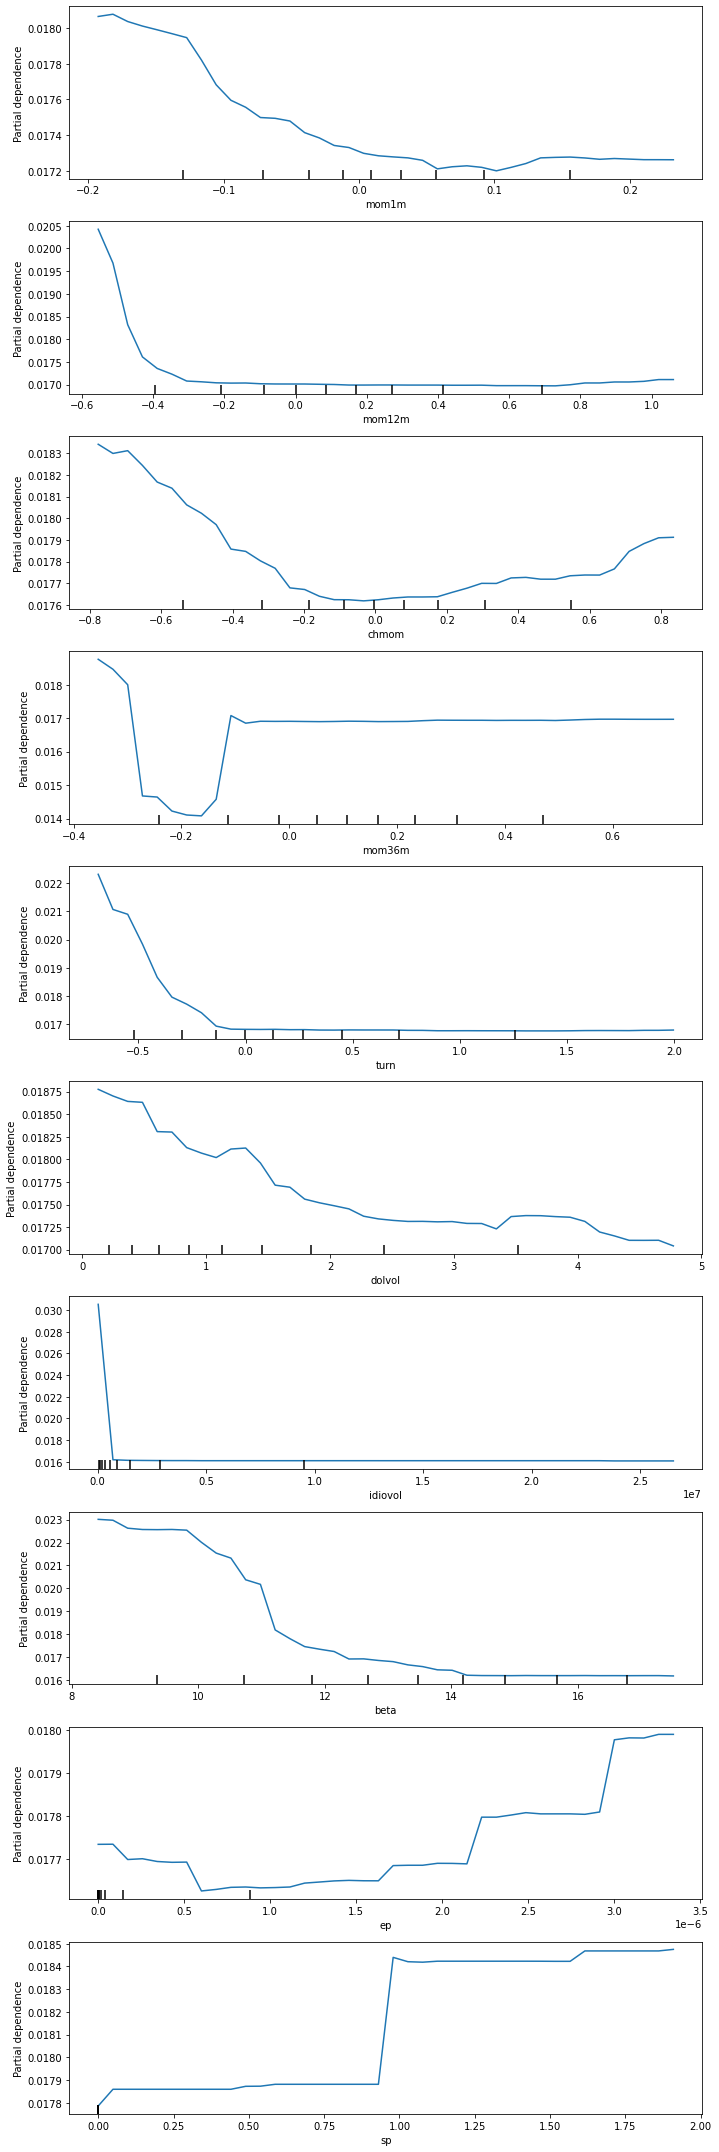

In [20]:
variables = ['mom1m', 'mom12m', 'chmom', 'mom36m', 'turn', 'dolvol', 'idiovol', 'beta','ep', 'sp']

fig, axs = plt.subplots(10, figsize=(10, 30))
for i, var in enumerate(variables):
    display = PartialDependenceDisplay.from_estimator(rf, X_train, features=[var], ax=axs[i], grid_resolution=40, feature_names=variables)
    
fig.tight_layout()
plt.show()

# ALE Curves

PyALE._ALE_generic:INFO: Continuous feature detected.


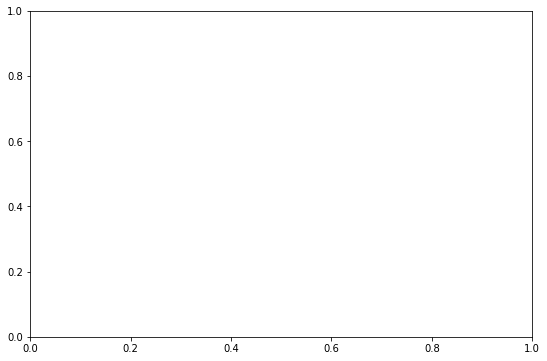

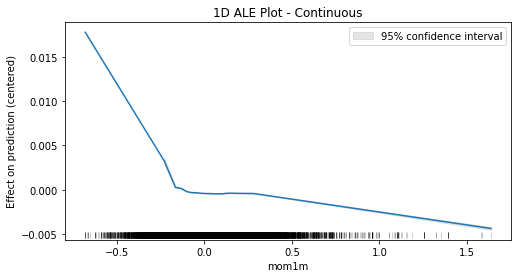

PyALE._ALE_generic:INFO: Continuous feature detected.


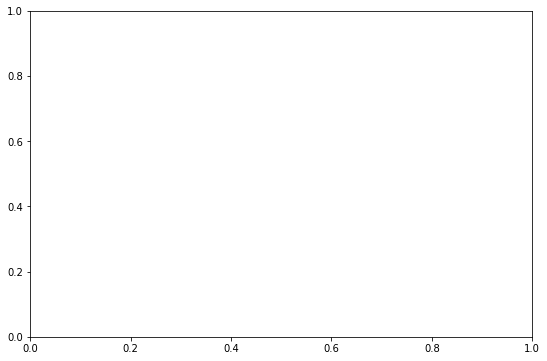

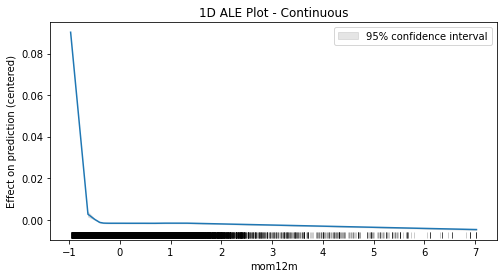

PyALE._ALE_generic:INFO: Continuous feature detected.


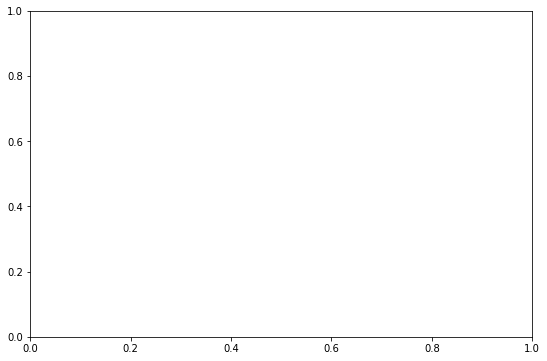

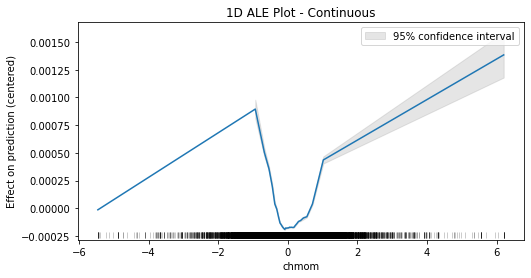

PyALE._ALE_generic:INFO: Continuous feature detected.


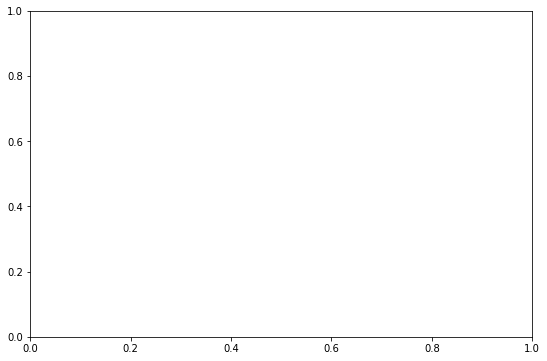

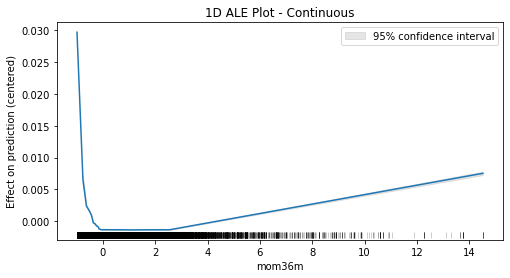

PyALE._ALE_generic:INFO: Continuous feature detected.


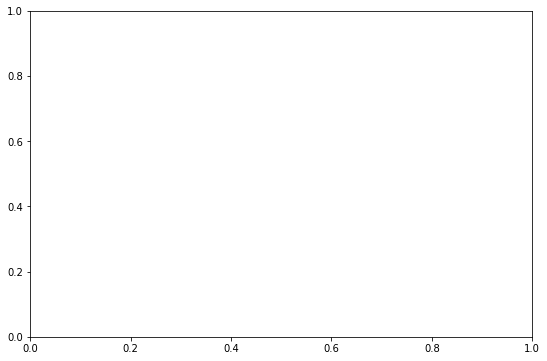

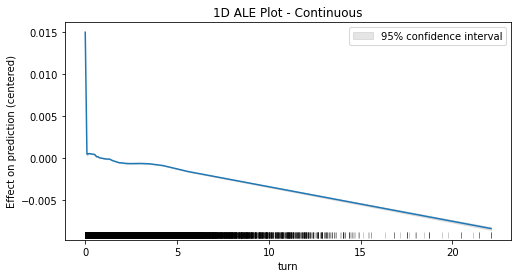

PyALE._ALE_generic:INFO: Continuous feature detected.


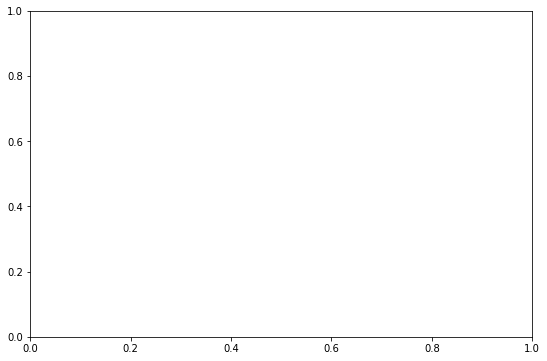

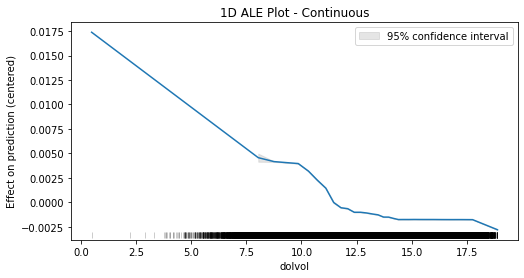

PyALE._ALE_generic:INFO: Continuous feature detected.


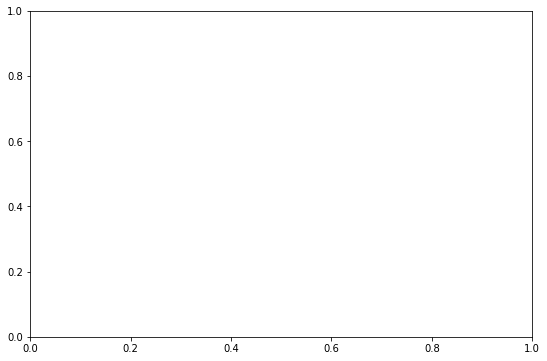

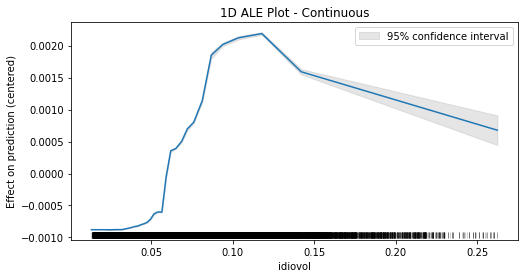

PyALE._ALE_generic:INFO: Continuous feature detected.


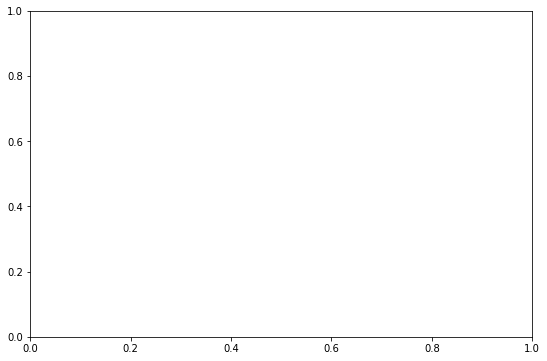

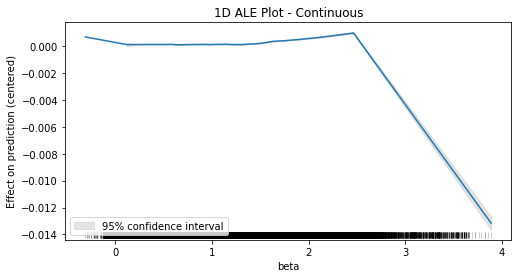

PyALE._ALE_generic:INFO: Continuous feature detected.


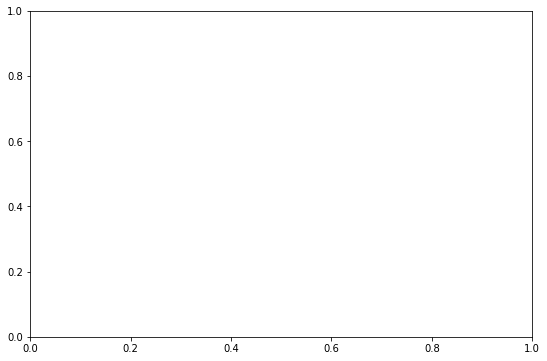

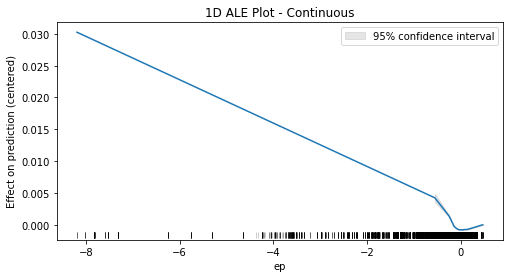

PyALE._ALE_generic:INFO: Continuous feature detected.


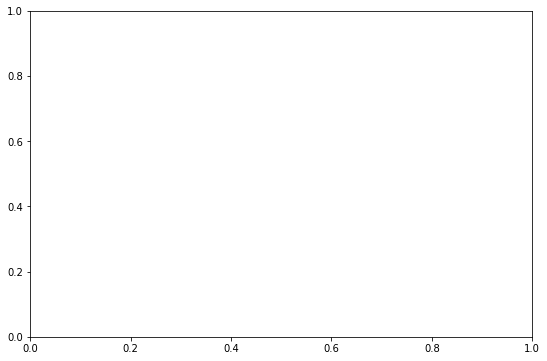

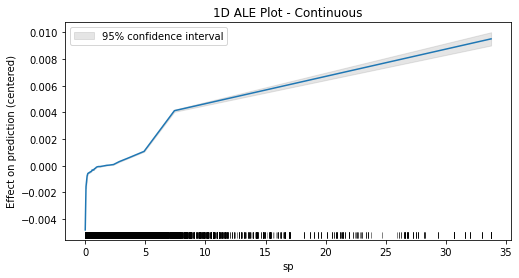

In [32]:
variables = ['mom1m', 'mom12m', 'chmom', 'mom36m', 'turn', 'dolvol', 'idiovol', 'beta','ep', 'sp']

for var in variables:
    fig, ax = plt.subplots(figsize=(9, 6))
    ale_plot = ale(X=X_train, model=rf, feature=[var], grid_size=30)
    plt.show()

# Explain Bins

In [21]:
dtype_specification = {'SICCD': str}
df = pd.read_csv('less_messy_data_keyword_LESS.csv', dtype=dtype_specification)
df = df.drop(columns = ['COMNAM', 'Unnamed: 0.1', 'Unnamed: 0', 'r(t+1)' , 'return'])

In [22]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['r(t+1)'], 
                                                   mode='regression')

In [23]:
#BIN 1
explanations1 = {}
#bins = df['bin1'].unique()

i = 0
for bin in bins:
    
    sample = bin.sample(n = 10)
    temp_exp = []
    
    for index, row in sample.iterrows():
        explanation = explainer.explain_instance(data_row = row[X_train.columns].values, 
                                                 predict_fn = rf.predict, 
                                                 num_features = 4)
        exp_map = dict(explanation.as_list())
        temp_exp.append(exp_map)
        
    explanations1[i] = temp_exp
    i += 1

/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/User

/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/User

/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/arthi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [24]:
summaries1 = {}

i = 0

for bin, explanations in explanations1.items():
    
    feat_imp = {}
    
    for exp in explanations:
                
        for feat, imp in exp.items():
                        
            if feat in feat_imp:
                
                feat_imp[feat].append(imp)
                
            else:
                
                feat_imp[feat] = [imp]
                
    all_importances = {feat: np.mean(imps) for feat, imps in feat_imp.items()}
    summaries1[i] = all_importances
    i += 1

bin_summary = pd.DataFrame(summaries1).fillna(0)
bin_summary

,0,1,2,3,4,5,6,7,8
dolvol <= 11.29,0.006329,0.006527,0.006287,0.006343,0.006410,0.006528,0.006423,0.006338,0.006406
mvel1 <= 144063.06,0.003680,0.003733,0.003517,0.003529,0.003655,0.003688,0.003727,0.003519,0.003665
indmom <= -0.06,0.002561,0.002393,0.002377,0.002522,0.002309,0.002733,0.002494,0.002807,0.000000
idiovol <= 0.04,-0.001529,0.000000,0.000000,0.000000,0.000000,-0.002013,0.000000,0.000000,0.000000
mom36m <= -0.21,0.003892,0.004037,0.004076,0.003972,0.003828,0.004045,0.003962,0.004075,0.004078
ep <= 0.01,0.004147,0.003922,0.003909,0.003981,0.004209,0.004059,0.004040,0.003867,0.004166
sp > 1.66,0.002997,0.000000,0.000000,0.003058,0.003107,0.002801,0.002817,0.003377,0.000000
return(t-1) <= -0.05,0.002963,0.002782,0.002499,0.002753,0.002349,0.002645,0.002762,0.002679,0.002368
idiovol > 0.07,0.003054,0.003209,0.000000,0.002938,0.002893,0.003132,0.003133,0.002984,0.002892
mom1m <= -0.05,0.002503,0.002291,0.002529,0.002288,0.002586,0.000000,0.002728,0.002759,0.002194


In [25]:
def plot_shap_feature_correlation(X_sample, shap_values, features):

    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.get_cmap('tab20', len(features))
    
    for i, feature in enumerate(features):
        sc = ax.scatter(X_sample[feature], shap_values[:, i],
                        color=colors(i), label=f"{feature}",
                        edgecolor='k', alpha=0.7, s=50)
    
    ax.set_title('SHAP values vs. Feature values')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('SHAP Value')
    ax.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/var/folders/6h/jvj1v_bx7kldrcbf4gl1ml7m0000gn/T/ipykernel_3387/2178730182.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(features))


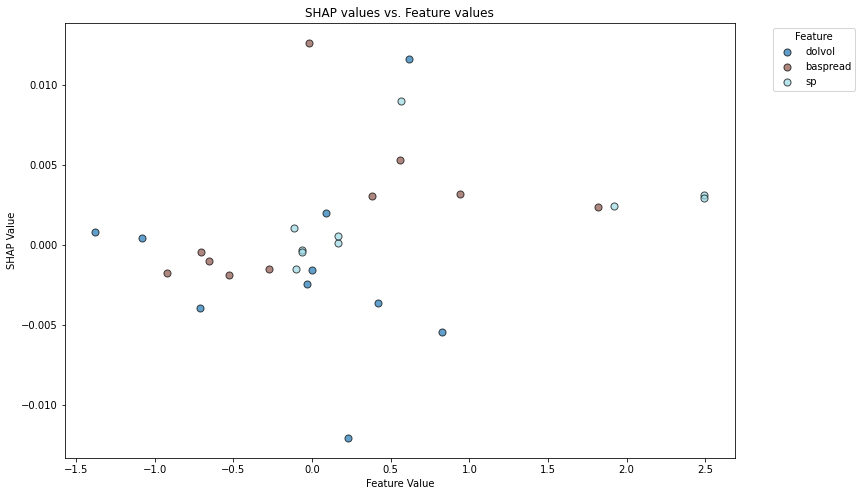

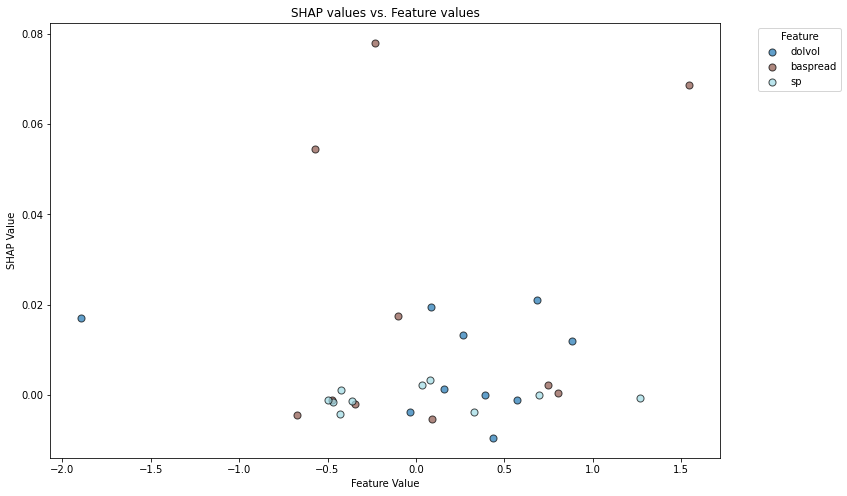

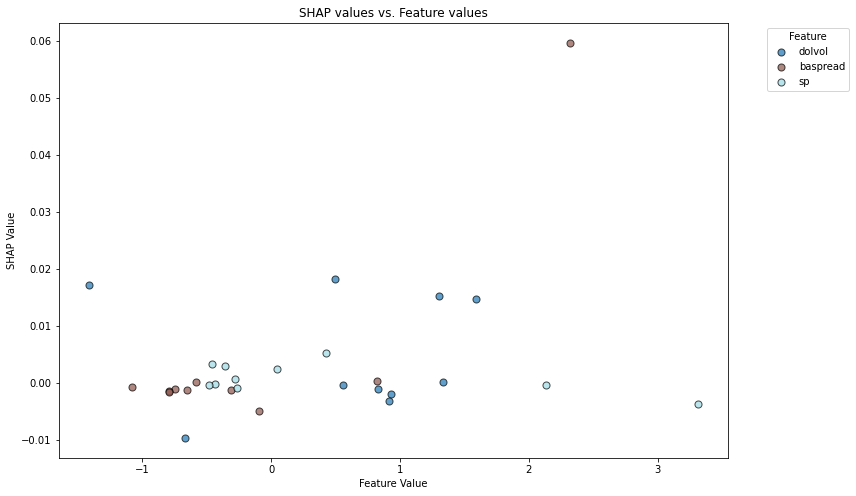

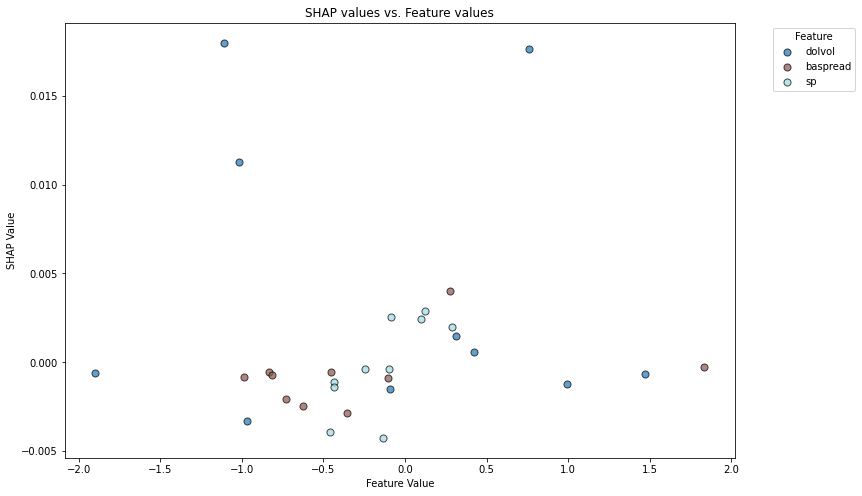

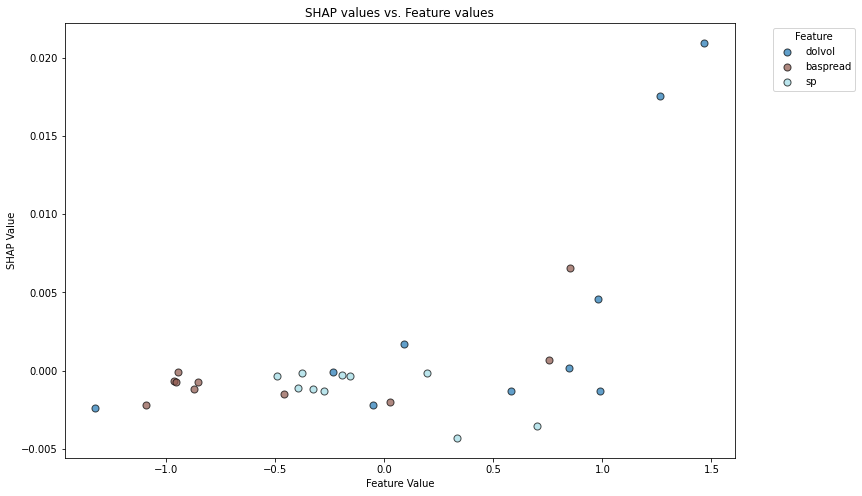

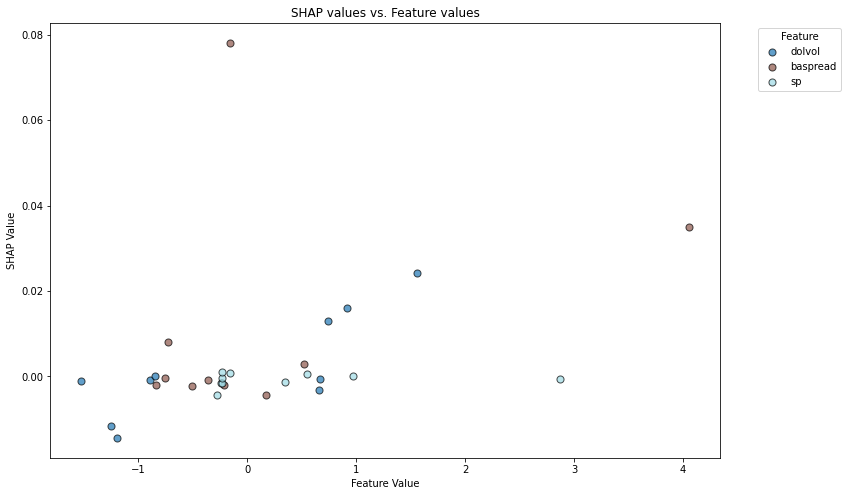

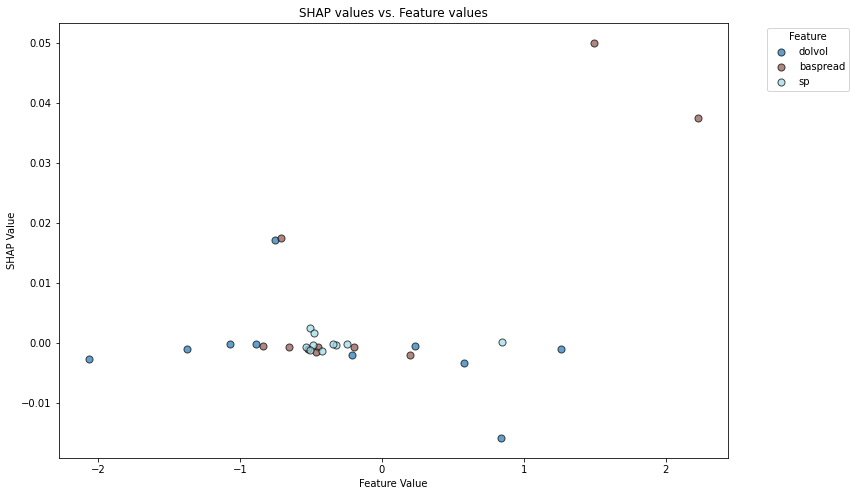

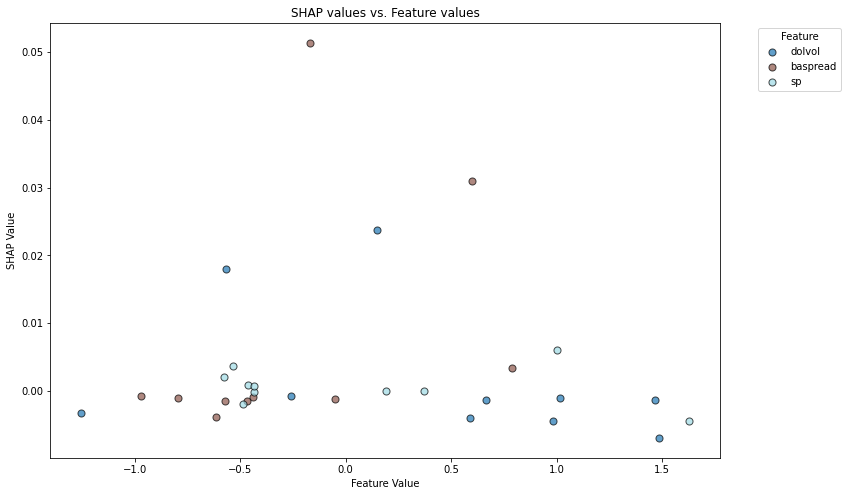

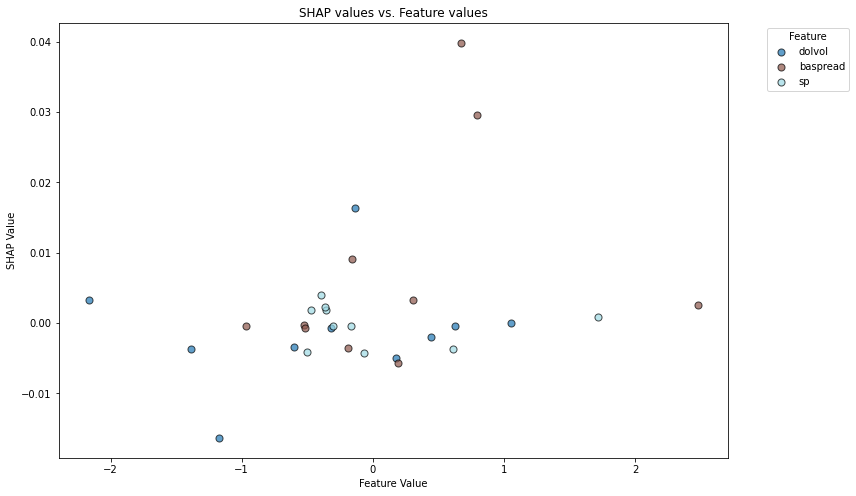

,0,1,2,3,4,5,6,7,8
mom1m,0.004388,0.009855,0.008165,0.005623,0.005223,0.008474,0.004385,0.006499,0.005139
mom12m,0.003307,0.023424,0.007225,0.001520,0.001627,0.013585,0.011180,0.009656,0.009520
chmom,0.002150,0.001928,0.002008,0.002125,0.001273,0.001186,0.000834,0.001995,0.002371
indmom,0.008966,0.022884,0.018860,0.016628,0.006503,0.017597,0.009596,0.009583,0.027274
mom36m,0.006061,0.003430,0.008150,0.001674,0.001267,0.003205,0.002263,0.005183,0.001808
turn,0.011373,0.005953,0.010848,0.013097,0.016130,0.009288,0.017243,0.009461,0.013200
mvel1,0.082189,0.070272,0.072443,0.070535,0.077410,0.074290,0.077965,0.070329,0.083957
dolvol,0.029573,0.035190,0.032367,0.031331,0.029003,0.033732,0.030639,0.030314,0.037968
ill,0.003352,0.002597,0.002116,0.000935,0.002687,0.001879,0.003750,0.001142,0.004718
zerotrade,0.000483,0.000588,0.000296,0.000701,0.000339,0.000210,0.000231,0.000254,0.000491


In [33]:
#BIN 1
explainer = shap.TreeExplainer(rf)
shap_values1 = {}
i = 0
for bin in bins:
    
    sample = bin.sample(n = 10)
    X_sample = sample[X_train.columns]
    temp_values = explainer.shap_values(X_sample)
    shap_values1[i] = temp_values
    i += 1
    
    variables = ['dolvol', 'baspread', 'sp']

    plot_shap_feature_correlation(X_sample, temp_values, variables)
    i += 1

summary1 = {}

i = 0
for bin, values in shap_values1.items():
    
    mean_values = np.abs(values).mean(axis=0)
    summary1[i] = dict(zip(X_train.columns, mean_values))
    i += 1

bin_shap_summary = pd.DataFrame(summary1).fillna(0)
bin_shap_summary